In [1]:
import numpy as np
import pandas as pd

In [10]:
import tensorflow as tf
from keras import layers
from keras import models

## Creating a model

In [3]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
Total params: 55,744
Trainable params: 55,744
Non-traina

In [4]:
# transform 3D vector to 1D vector
model.add(layers.Flatten())

# classification network
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

## Downloading MNIST dataset

In [5]:
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [6]:
(X, y), (X_test, y_test) = mnist.load_data()
type(X), X.shape

numpy.ndarray

In [7]:
X = X.reshape(X.shape[0], 28, 28, 1)
X = X / 255.

X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_test = X_test / 255.

y = to_categorical(y)
y_test = to_categorical(y_test)

## Fit the model

In [8]:
# split train dataset into train and validation datasets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [32]:
# callbacks
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)

# tensorboard callback
import datetime

log_dir = 'log\\fit\\' + datetime.datetime.now().strftime("%d-%m-%Y %H-%M-%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

In [33]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

model.fit(X_train, y_train, epochs = 20, batch_size = 64, 
          validation_data = (X_val, y_val), 
          callbacks = [tensorboard_callback, early_stop_callback])

Epoch 1/20
750/750 [==============================] - 31s 39ms/step - loss: 0.0074 - accuracy: 0.9976 - val_loss: 0.0531 - val_accuracy: 0.9891
Epoch 2/20
750/750 [==============================] - 21s 28ms/step - loss: 0.0060 - accuracy: 0.9980 - val_loss: 0.0707 - val_accuracy: 0.9868
Epoch 3/20
750/750 [==============================] - 24s 32ms/step - loss: 0.0065 - accuracy: 0.9980 - val_loss: 0.0526 - val_accuracy: 0.9894
Epoch 4/20
750/750 [==============================] - 26s 34ms/step - loss: 0.0063 - accuracy: 0.9977 - val_loss: 0.0429 - val_accuracy: 0.9911
Epoch 5/20
750/750 [==============================] - 24s 32ms/step - loss: 0.0028 - accuracy: 0.9990 - val_loss: 0.0468 - val_accuracy: 0.9912
Epoch 6/20
750/750 [==============================] - 28s 37ms/step - loss: 0.0052 - accuracy: 0.9982 - val_loss: 0.0431 - val_accuracy: 0.9918
Epoch 7/20
750/750 [==============================] - 22s 30ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.0511 - val_accuracy:

In [34]:
test_loss, test_acc = model.evaluate(X_test, y_test)
test_loss, test_acc

313/313 [==============================] - 4s 11ms/step - loss: 0.0372 - accuracy: 0.9923


(0.037238746881484985, 0.9922999739646912)

In [35]:
y_pred = model.predict(X_test)
y_pred[0]

array([1.6693382e-17, 4.4047211e-16, 1.5473043e-18, 2.0435221e-17,
       2.9514835e-11, 5.8201238e-16, 3.3118696e-24, 1.0000000e+00,
       1.5702709e-15, 6.0963496e-14], dtype=float32)

In [36]:
y_pred = [np.argmax(i) for i in y_pred]
y_pred[0]

7

In [37]:
ind = []

for i in range(len(y_pred)):
    if np.argmax(y_test[i]) != y_pred[i]:
        ind.append(i)

In [38]:
import matplotlib.pyplot as plt

Predicted:  7
Real:  2


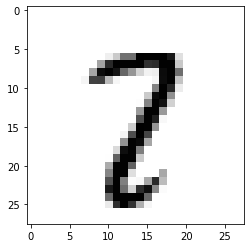

Predicted:  3
Real:  5


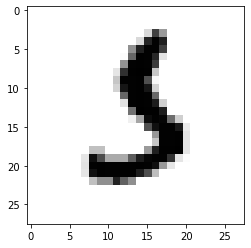

Predicted:  1
Real:  2


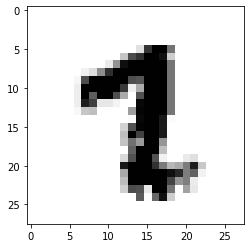

Predicted:  3
Real:  5


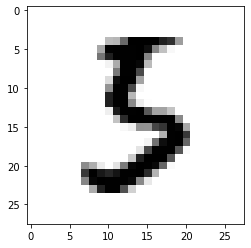

Predicted:  8
Real:  5


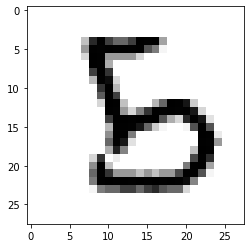

Predicted:  1
Real:  9


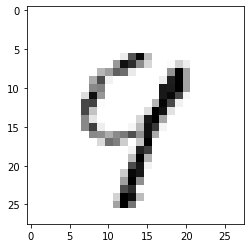

Predicted:  3
Real:  1


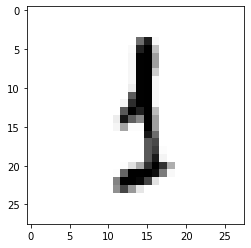

Predicted:  7
Real:  2


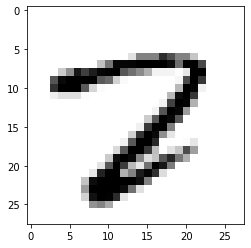

Predicted:  9
Real:  8


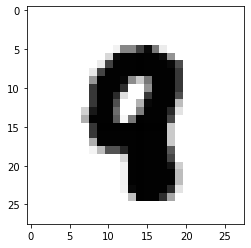

Predicted:  5
Real:  6


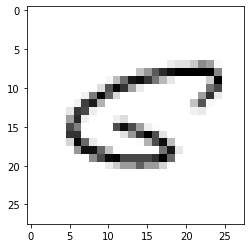

In [39]:
for i in ind[:10]:
    print('Predicted: ', y_pred[i])
    print('Real: ', np.argmax(y_test[i]))
    digit = X_test[i].reshape(28, 28)
    plt.imshow(digit, cmap=plt.cm.binary)
    plt.show()

## TensorBoard

In [42]:
# Loading the Tensorboard extension
%load_ext tensorboard
%tensorboard --logdir "log/fit"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
